In [1]:
%matplotlib inline

In [2]:
import requests
import json
import geopandas as gpd
import pandas as pd
import ast

In [3]:
# Download locally the GeoJSON files from http://eric.clst.org/Stuff/USGeoJSON
!mkdir -p data

!curl 'http://eric.clst.org/wupl/Stuff/gz_2010_us_040_00_500k.json' -o 'data/us_states_high_detail.json'
#!curl 'http://eric.clst.org/wupl/Stuff/gz_2010_us_040_00_5m.json'   -o 'data/us_states_medium_detail.json'
#!curl 'http://eric.clst.org/wupl/Stuff/gz_2010_us_040_00_20m.json'  -o 'data/us_states_low_detail.json'

!curl 'http://eric.clst.org/wupl/Stuff/gz_2010_us_050_00_500k.json' -o 'data/us_counties_high_detail.json'
#!curl 'http://eric.clst.org/wupl/Stuff/gz_2010_us_050_00_5m.json '  -o 'data/us_counties_medium_detail.json'
#!curl 'http://eric.clst.org/wupl/Stuff/gz_2010_us_050_00_20m.json'  -o 'data/us_counties_low_detail.json'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2432k  100 2432k    0     0  3284k      0 --:--:-- --:--:-- --:--:-- 3287k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.4M  100 22.4M    0     0  7240k      0  0:00:03  0:00:03 --:--:-- 7241k


In [4]:
geojson=open('data/us_states_high_detail.json', 'r').read()
states_geojson = json.loads(geojson)["features"]
df_states = gpd.GeoDataFrame.from_features(states_geojson)
df_states = df_states[ df_states.STATE!='02' ] #drop Alaska
df_states = df_states[ df_states.STATE!='15' ] #drop Hawaii
df_states = df_states[ df_states.STATE!='72' ] #drop Puerto Rico
df_states.set_index('STATE',inplace=True)
df_states.sort_index(inplace=True)


In [5]:
df_states.head()

,CENSUSAREA,GEO_ID,LSAD,NAME,geometry
STATE,,,,,
01,50645.326,0400000US01,,Alabama,"(POLYGON ((-85.002368 31.000682, -85.024108 31..."
04,113594.084,0400000US04,,Arizona,"POLYGON ((-109.045223 36.999084, -109.045244 3..."
05,52035.477,0400000US05,,Arkansas,"POLYGON ((-94.55929 36.499496, -94.51947800000..."
06,155779.220,0400000US06,,California,"(POLYGON ((-122.446316 37.861046, -122.438565 ..."
08,103641.888,0400000US08,,Colorado,"POLYGON ((-102.04224 36.993083, -102.054503 36..."


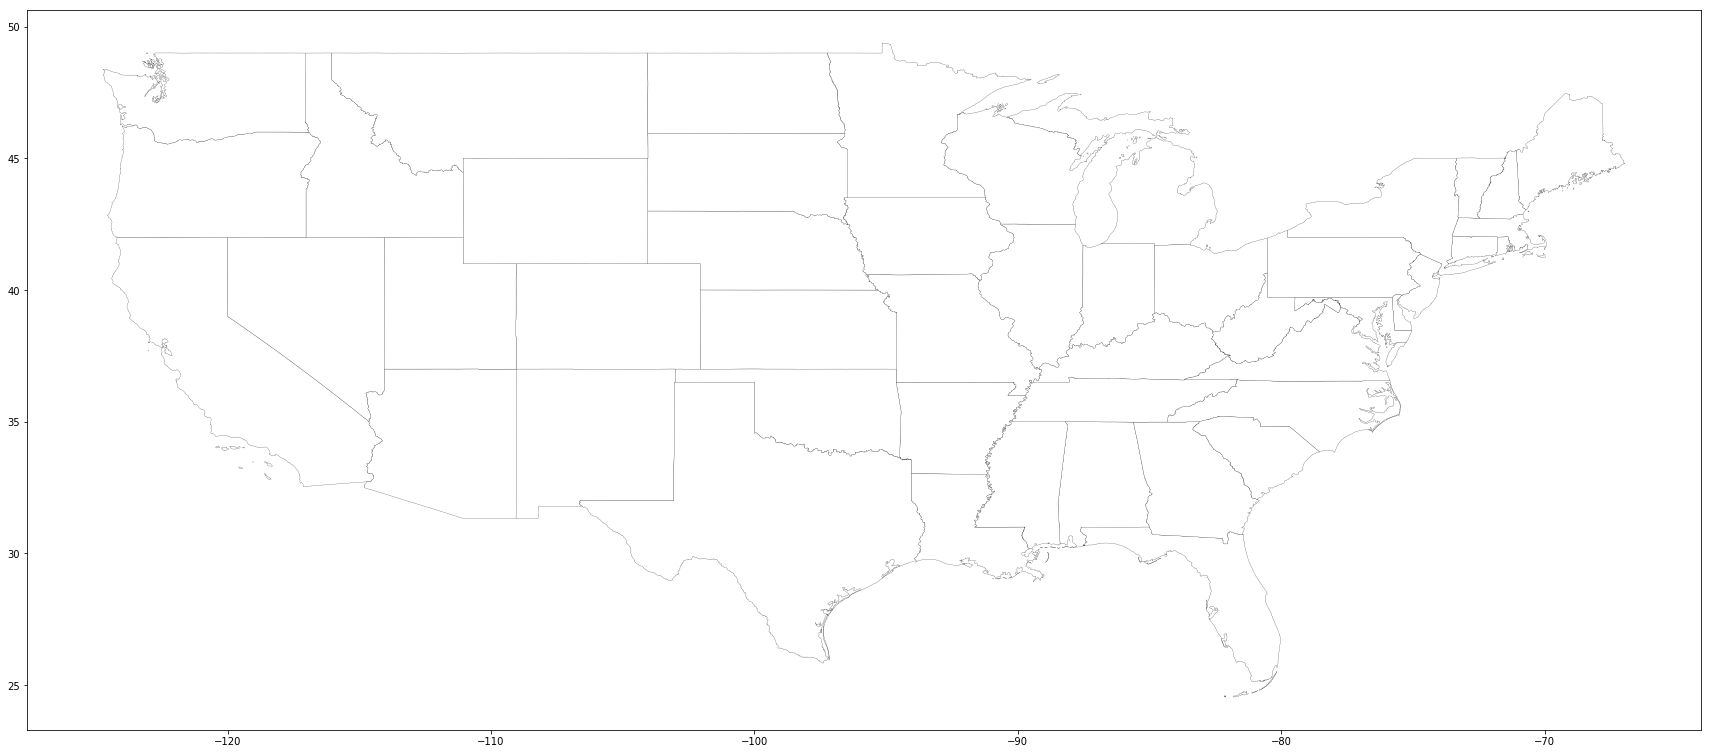

In [6]:
df_states.plot(
    figsize=(30,30), 
    linewidth=0.2, 
    color='white', 
    edgecolor='black')

In [7]:
# US Counties GeoJSON
geojson=open('data/us_counties_high_detail.json', 'r', encoding = "ISO-8859-1").read()
counties_geojson = json.loads(geojson)["features"]
df_counties = gpd.GeoDataFrame.from_features(counties_geojson)

In [8]:
df_counties=df_counties[ df_counties.STATE!='02' ] #drop Alaska
df_counties=df_counties[ df_counties.STATE!='15' ] #drop Hawaii
df_counties=df_counties[ df_counties.STATE!='72' ] #drop Puerto Rico


In [9]:
df_counties.set_index(['STATE','COUNTY'],inplace=True)
df_counties.sort_index(inplace=True)

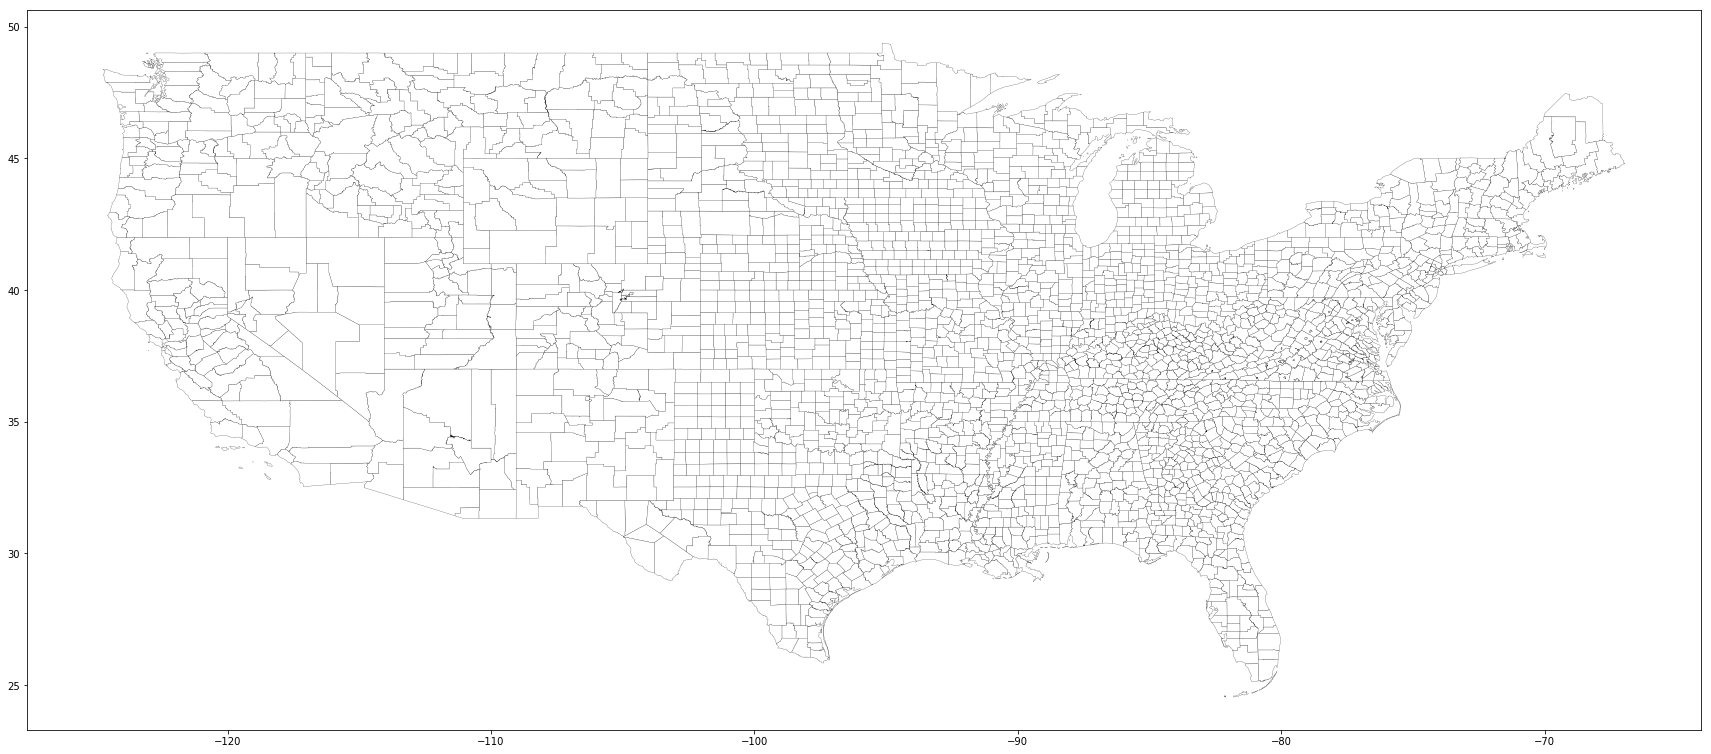

In [10]:
df_counties.plot(
    figsize=(30,30), 
    linewidth=0.2,  
    color='white', 
    edgecolor='black'
)

### Getting Census Data

First of all, you need to get an API Key from http://api.census.gov/data/key_signup.html.

In [11]:
class Census:
    def __init__(self, key):
        self.key = key

    def get(self, fields, geo, year=2010, dataset='sf1'):
        fields = [','.join(fields)]
        template_url = 'https://api.census.gov/data/{year}/{dataset}?key={key}&get='
        base_url = template_url.format(year=str(year), dataset=dataset, key=self.key)
        query = fields
        for item in geo:
            query.append(item)
        add_url = '&'.join(query)
        url = base_url + add_url
        response = requests.get(url)
        return response.text

api_key = '627d4107b57d4576f2120d2b87b59c7440e5d2af'
census = Census(api_key)

In [12]:
state = census.get(['P0010001'], ['for=state:*'])
df_state_population = pd.DataFrame(ast.literal_eval(state), columns = ['Population', 'STATE'])
df_state_population['Population'] = pd.to_numeric(df_state_population['Population'],errors='coerce')
df_state_population.drop(0,axis=0,inplace=True)
df_state_population.set_index('STATE',inplace=True)
df_state_population.sort_index(inplace=True)
#df_state_population

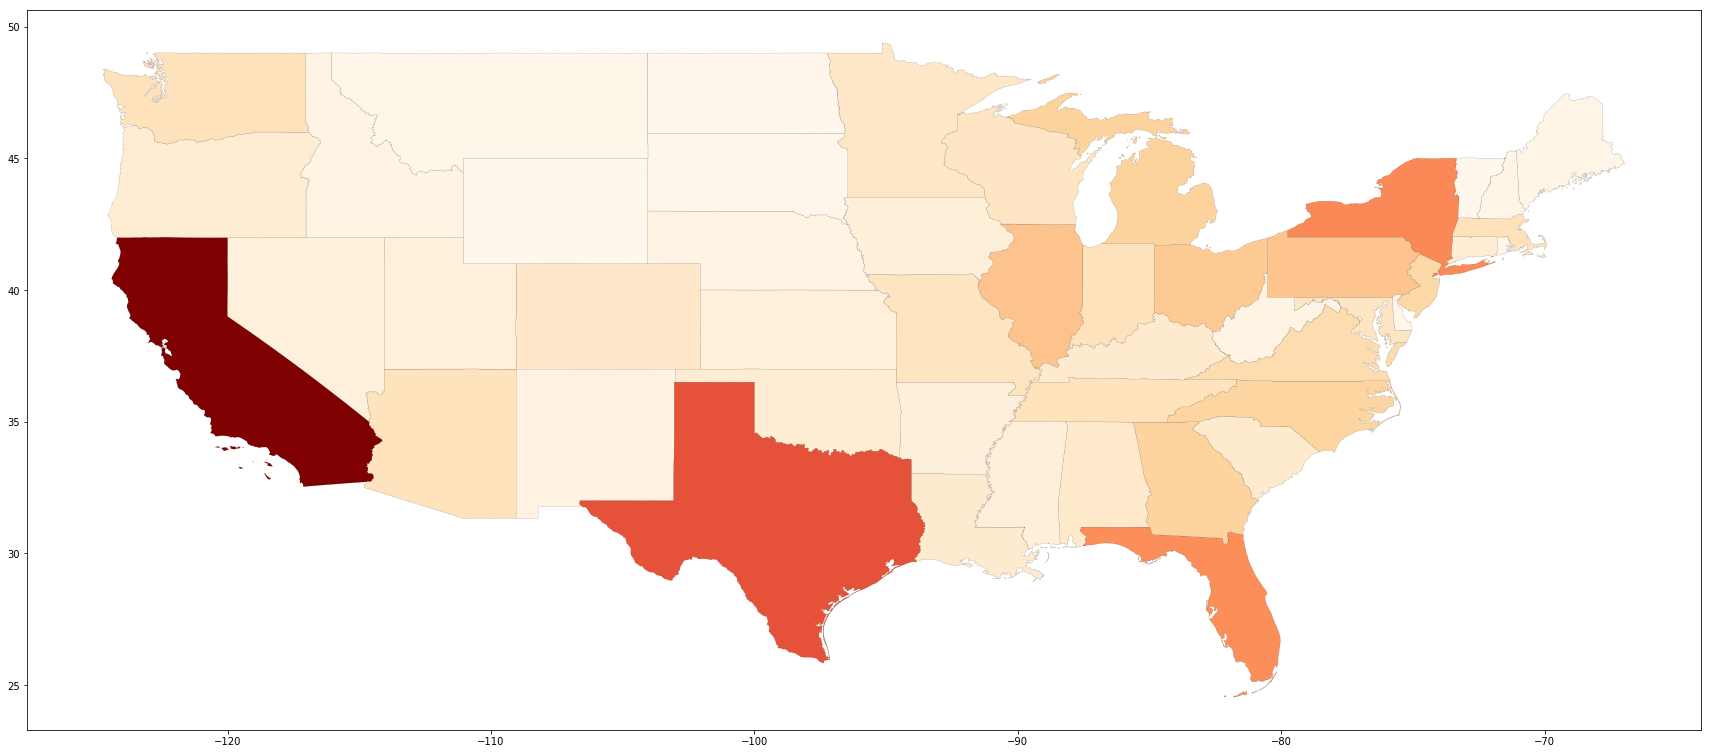

In [13]:
df_states.join(df_state_population).plot(
    figsize=(30,30), 
    column='Population', 
    cmap='OrRd',  # select color scheme from http://matplotlib.org/users/colormaps.html
    linewidth=0.1, 
    edgecolor='black'
)

In [14]:
import math
county = census.get(['P0010001'], ['in=state:*', 'for=county:*'])
df_county_population = pd.DataFrame(ast.literal_eval(county), columns = ['Population', 'STATE', 'COUNTY'])
df_county_population['Population'] = pd.to_numeric(df_county_population['Population'],errors='coerce')
df_county_population.drop(0,axis=0,inplace=True)
df_county_population.set_index(['STATE','COUNTY'],inplace=True)
df_state_population.sort_index(inplace=True)

# county_result = ast.literal_eval(county)

In [15]:
# df_county_population['LogPopulation'] = df_county_population['Population'].apply(math.log)

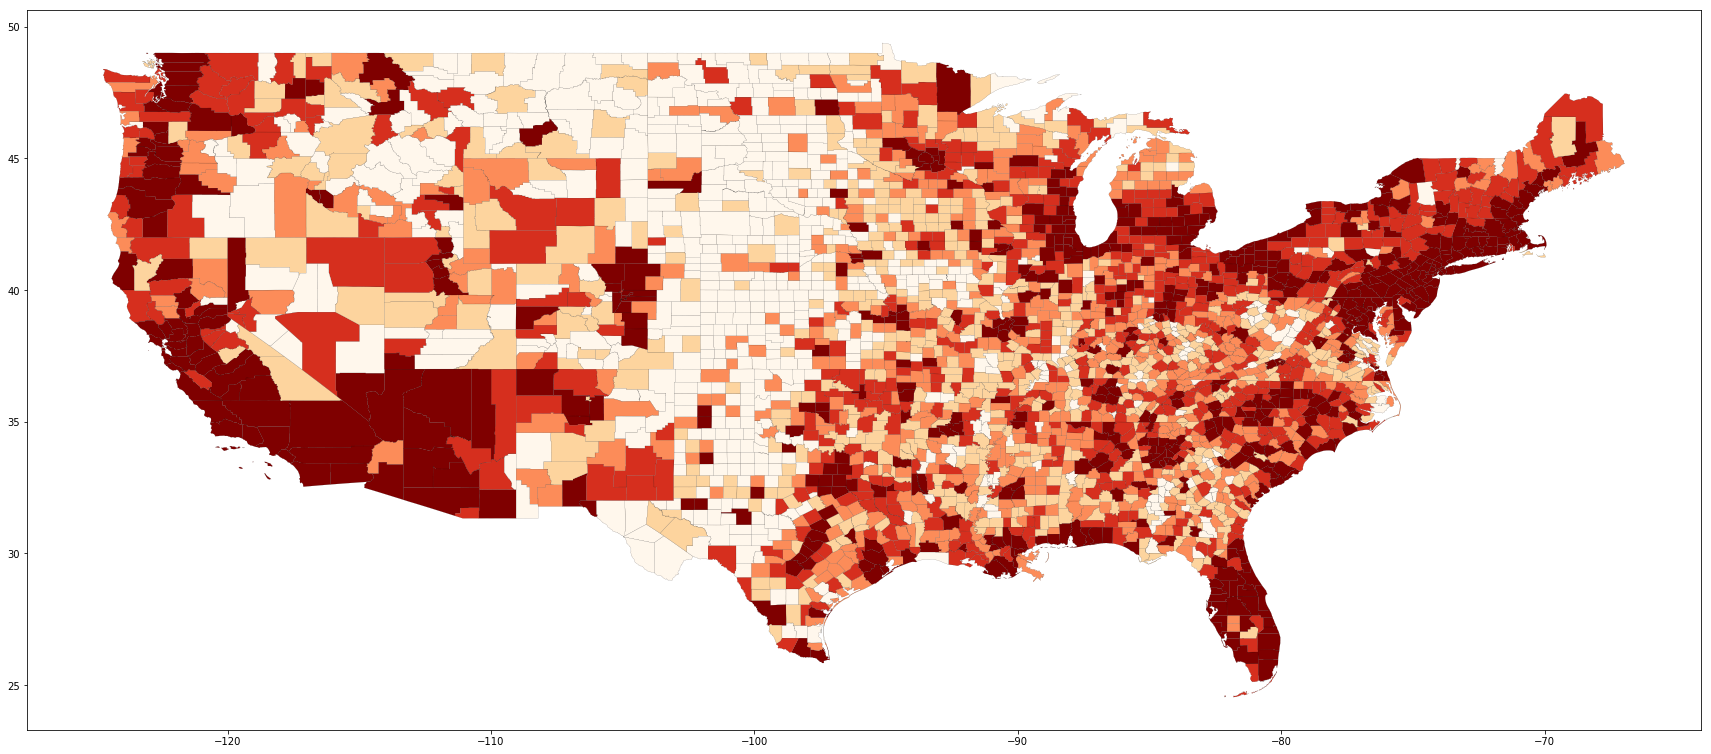

In [16]:
df_counties.join(df_county_population).plot(
    figsize=(30,30), 
    column='Population', 
    cmap='OrRd', # http://matplotlib.org/users/colormaps.html
    scheme='Quantiles', # alternatives are 'Quantiles', Equal_Interval', and 'Fisher_Jenks'
    linewidth=0.1, 
    edgecolor='black')